In [1]:
test_result_dir = '../test_results'

import os
files = os.listdir(test_result_dir)
files

['smq_0000000001000.json',
 'smq_0000000001000_receive.json',
 'smq_0000000001000_send.json',
 'smq_0000000010000.json',
 'smq_0000000010000_receive.json',
 'smq_0000000010000_send.json',
 'smq_0000000100000.json',
 'smq_0000000100000_receive.json',
 'smq_0000000100000_send.json',
 'smq_0000001000000.json',
 'smq_0000001000000_receive.json',
 'smq_0000001000000_send.json',
 'smq_0000010000000.json',
 'smq_0000010000000_receive.json',
 'smq_0000010000000_send.json',
 'smq_0000100000000.json',
 'smq_0000100000000_receive.json',
 'smq_0000100000000_send.json',
 'smq_0001000000000.json',
 'smq_0001000000000_receive.json',
 'smq_0001000000000_send.json',
 'smq_0010000000000.json',
 'smq_0010000000000_receive.json',
 'smq_0010000000000_send.json',
 'standard_0000000001000.json',
 'standard_0000000001000_receive.json',
 'standard_0000000001000_send.json',
 'standard_0000000010000.json',
 'standard_0000000010000_receive.json',
 'standard_0000000010000_send.json',
 'standard_0000000100000.json'

In [7]:
import json
from performance_test_base import package_sizes

def load_data(type_, package, suffix):
    f_stats = os.path.join(test_result_dir, f'{type_}_{package:013d}{suffix}.json')
    if not os.path.exists(f_stats):
        print(f"File {f_stats} does not exist.")
        return None
    with open(f_stats) as f:
        data = json.load(f)
    return data

data = {}
for package in package_sizes:
    std_stats = load_data('standard', package, '')
    std_send = load_data('standard', package, '_send')
    std_recv = load_data('standard', package, '_receive')
    smq_stats = load_data('smq', package, '')
    smq_send = load_data('smq', package, '_send')
    smq_recv = load_data('smq', package, '_receive')
    data[package] = {
        'std_stats': std_stats,
        'std_send': std_send,
        'std_recv': std_recv,
        'smq_stats': smq_stats,
        'smq_send': smq_send,
        'smq_recv': smq_recv
    }

File ../test_results\standard_0010000000000.json does not exist.
File ../test_results\standard_0010000000000_send.json does not exist.
File ../test_results\standard_0010000000000_receive.json does not exist.


In [9]:
labels = [
    f"{s//1000}KB" if s < 1_000_000
    else f"{s//1_000_000}MB" if s < 1_000_000_000
    else f"{s//1_000_000_000}GB"
    for s in package_sizes
]
labels

['1KB', '10KB', '100KB', '1MB', '10MB', '100MB', '1GB', '10GB']

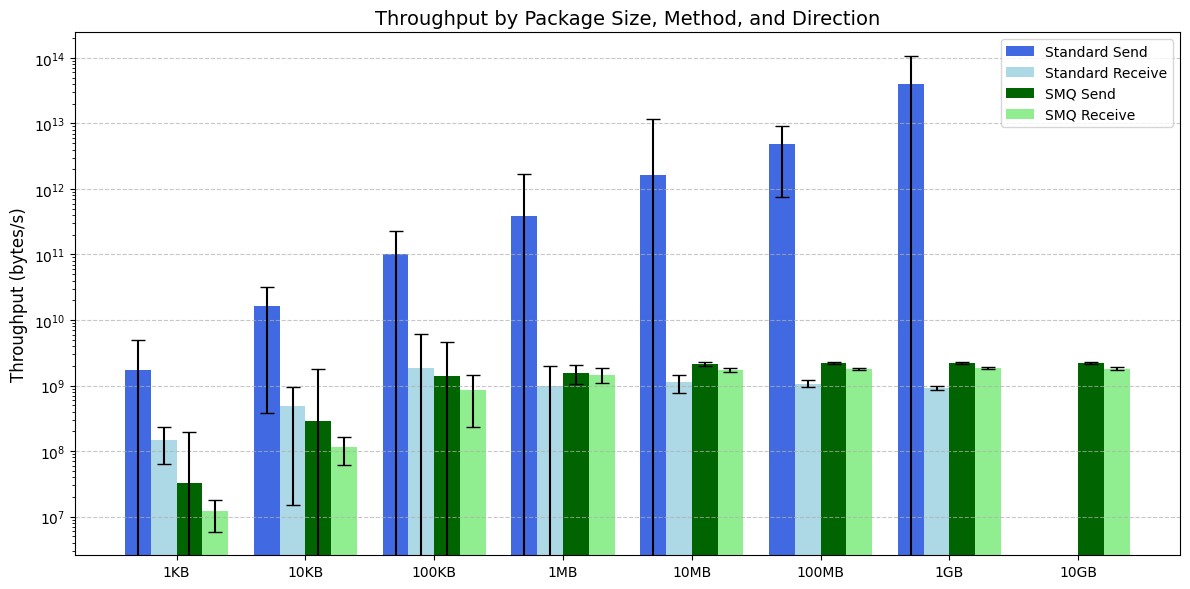

In [24]:
import numpy as np
import matplotlib.pyplot as plt

# Calculate throughput (bytes/second) for each method and direction
std_send_throughput = []
std_recv_throughput = []
smq_send_throughput = []
smq_recv_throughput = []

# Calculate standard errors
std_send_error = []
std_recv_error = []
smq_send_error = []
smq_recv_error = []

for size in package_sizes:
    pkg_data = data[size]
    
    # Standard Queue Send
    if pkg_data['std_send'] is not None:
        mean_time = pkg_data['std_send']['mean']
        std_dev = pkg_data['std_send']['std']
        std_send_throughput.append(size / mean_time if mean_time > 0 else 0)
        std_send_error.append((size / mean_time) * (std_dev / mean_time) if mean_time > 0 else 0)
    else:
        std_send_throughput.append(0)
        std_send_error.append(0)
    
    # Standard Queue Receive
    if pkg_data['std_recv'] is not None:
        mean_time = pkg_data['std_recv']['mean']
        std_dev = pkg_data['std_recv']['std']
        std_recv_throughput.append(size / mean_time if mean_time > 0 else 0)
        std_recv_error.append((size / mean_time) * (std_dev / mean_time) if mean_time > 0 else 0)
    else:
        std_recv_throughput.append(0)
        std_recv_error.append(0)
    
    # Shared Memory Queue Send
    if pkg_data['smq_send'] is not None:
        mean_time = pkg_data['smq_send']['mean']
        std_dev = pkg_data['smq_send']['std']
        smq_send_throughput.append(size / mean_time if mean_time > 0 else 0)
        smq_send_error.append((size / mean_time) * (std_dev / mean_time) if mean_time > 0 else 0)
    else:
        smq_send_throughput.append(0)
        smq_send_error.append(0)
    
    # Shared Memory Queue Receive
    if pkg_data['smq_recv'] is not None:
        mean_time = pkg_data['smq_recv']['mean']
        std_dev = pkg_data['smq_recv']['std']
        smq_recv_throughput.append(size / mean_time if mean_time > 0 else 0)
        smq_recv_error.append((size / mean_time) * (std_dev / mean_time) if mean_time > 0 else 0)
    else:
        smq_recv_throughput.append(0)
        smq_recv_error.append(0)

# Setting up the plot
x = np.arange(len(labels))
width = 0.2

fig, ax = plt.subplots(figsize=(12, 6))

# Plot bars
rects1 = ax.bar(x - width*1.5, std_send_throughput, width, label='Standard Send', color='royalblue', yerr=std_send_error, capsize=5)
rects2 = ax.bar(x - width/2, std_recv_throughput, width, label='Standard Receive', color='lightblue', yerr=std_recv_error, capsize=5)
rects3 = ax.bar(x + width/2, smq_send_throughput, width, label='SMQ Send', color='darkgreen', yerr=smq_send_error, capsize=5)
rects4 = ax.bar(x + width*1.5, smq_recv_throughput, width, label='SMQ Receive', color='lightgreen', yerr=smq_recv_error, capsize=5)

# Set up labels and title
ax.set_ylabel('Throughput (bytes/s)', fontsize=12)
ax.set_title('Throughput by Package Size, Method, and Direction', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_yscale('log')
ax.legend()

# Add horizontal grid lines for better readability
ax.grid(axis='y', linestyle='--', alpha=0.7)

# Adjust layout and display the plot
fig.tight_layout()
plt.show()

---

In [51]:
test_result_dir = '../test_results'

import os
files = os.listdir(test_result_dir)
files

['smq_e2e_0000000001000.json',
 'smq_e2e_0000000010000.json',
 'smq_e2e_0000000100000.json',
 'smq_e2e_0000001000000.json',
 'smq_e2e_0000010000000.json',
 'smq_e2e_0000100000000.json',
 'smq_e2e_0001000000000.json',
 'smq_e2e_0010000000000.json',
 'standard_e2e_0000000001000.json',
 'standard_e2e_0000000010000.json',
 'standard_e2e_0000000100000.json',
 'standard_e2e_0000001000000.json',
 'standard_e2e_0000010000000.json',
 'standard_e2e_0000100000000.json',
 'standard_e2e_0001000000000.json']

In [58]:
import json
from performance_test_base import package_sizes

def load_data(type_, package):
    f_stats = os.path.join(test_result_dir, f'{type_}_{package:013d}.json')
    if not os.path.exists(f_stats):
        print(f"File {f_stats} does not exist.")
        return None
    with open(f_stats) as f:
        data = json.load(f)
    return data

data_std = {}
data_smq = {}
for package in package_sizes:
    data_std[package] = load_data('standard_e2e', package)
    data_smq[package] = load_data('smq_e2e', package)

File ../test_results\standard_e2e_0010000000000.json does not exist.


In [61]:
data_std[1000]

{'start': 941341.8753034,
 'end': 941371.8753238,
 'duration': 30.00002040003892,
 'count': 1330202,
 'mean': 2.2552980975850976e-05,
 'std_dev': 2.0503927385862592e-05,
 'bytes_per_second': 44340036.51538431,
 'size': 1000}

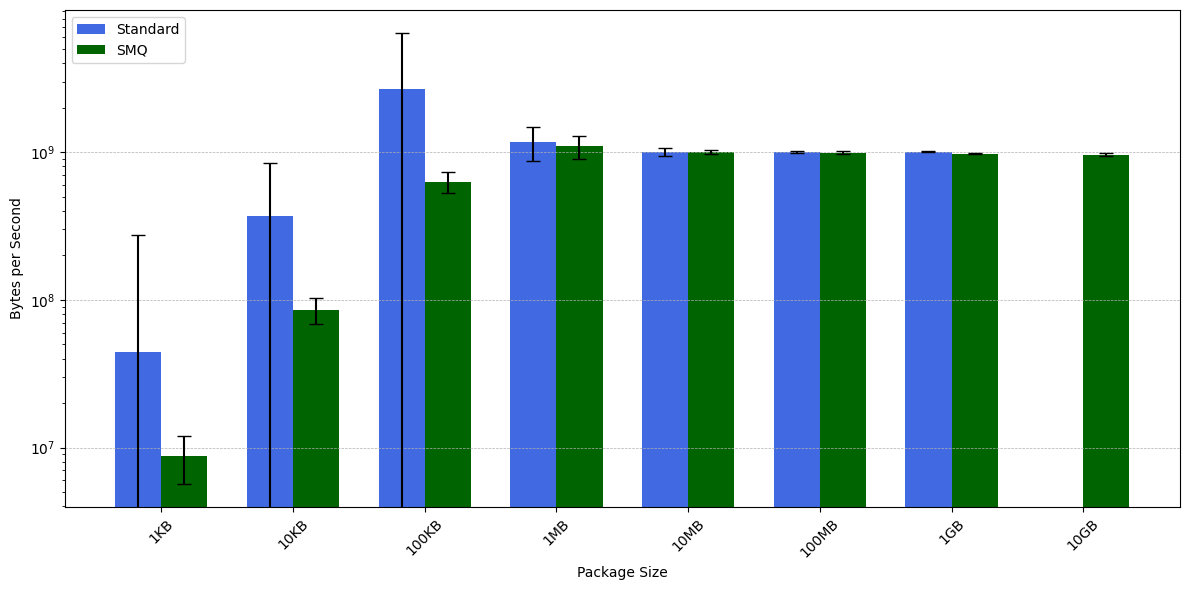

In [69]:
import os
import matplotlib.pyplot as plt
import numpy as np

x = np.arange(len(package_sizes))
width = 0.35

def calc_error(entry):
    if not entry:
        return np.nan
    
    # Get the standard deviation in time (seconds)
    time_std_dev = entry["std_dev"]
    
    # Get the mean time per operation
    mean_time = entry["mean"]
    
    # Calculate size and count
    size = entry["size"]
    count = entry["count"]
    
    # Calculate bytes per second using mean + std_dev and mean - std_dev
    bytes_per_second_upper = size / (mean_time - time_std_dev) if mean_time > time_std_dev else np.nan
    bytes_per_second_lower = size / (mean_time + time_std_dev)
    
    # Calculate the average error
    bytes_per_second = entry["bytes_per_second"]
    error_upper = abs(bytes_per_second_upper - bytes_per_second) if not np.isnan(bytes_per_second_upper) else 0
    error_lower = abs(bytes_per_second - bytes_per_second_lower)
    
    # Return the average error
    return (error_upper + error_lower) / 2

std_throughput = [data_std[p]["bytes_per_second"] if data_std[p] else np.nan for p in package_sizes]
smq_throughput = [data_smq[p]["bytes_per_second"] if data_smq[p] else np.nan for p in package_sizes]

std_error = [calc_error(data_std[p]) for p in package_sizes]
smq_error = [calc_error(data_smq[p]) for p in package_sizes]

fig, ax = plt.subplots(figsize=(12, 6))
ax.bar(x - width/2, std_throughput, width, yerr=std_error, label='Standard', capsize=5, color='royalblue')
ax.bar(x + width/2, smq_throughput, width, yerr=smq_error, label='SMQ', capsize=5, color='darkgreen')

ax.set_yscale('log')
ax.set_xlabel('Package Size')
ax.set_ylabel('Bytes per Second')
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=45)
ax.legend()
ax.grid(True, axis='y', linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.show()
